- In this notebook, I trained the PNet, which is first part of the MTCNN model. 
- Besides, I showed detailed comments of the codes and some formulas in this notebook.  
- In order to be more concise, I will not show the repetitive parts in other notebooks. 

## Import package

In [1]:
# torch 
import torch
import torch.nn as nn
import torch.optim as opt
import torch.utils.data as data
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
# read file
import os.path as osp
import os
# read & show images
import PIL
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
# random choose
import numpy as np
from numpy import random
from numpy.random import uniform
from random import shuffle
# others
import time
import math
import argparse
import warnings
import copy
warnings.filterwarnings("ignore")

## Read Pnet txt file
- Here is an example of the lines in the 'wider_face_train_bbx_gt.txt' file:
        32--Worker_Laborer/32_Worker_Laborer_Worker_Laborer_32_931.jpg
        3
        87 99 30 24 2 0 0 0 0 0 
        612 125 29 28 2 0 0 0 0 0 
        901 343 20 20 2 0 0 0 0 0 
  The first line shows the image path, the second line shows the number of boxes, and the following lines show these information of the box:
      x1, y1, w, h, blur, expression, illumination, invalid, occlusion, pose
  We only need the first 4 figures ( x1, y1, w, h ) in this task
  

- In this part, the output is a list of :
        [image path, [x1, y1, w, h]]
        
- The output will be the input of the InplaceDataSet function

In [3]:
def create_pnet_data_txt_parser(txt_path, img_dir,num_data=5000):
    """
    :param txt_path: the path of wider_face_train_bbx_gt.txt
    :param img_dir: tha dir of WIDER/WIDER_train
    :return: img_faces type is list, shape is [img_num*[absolute_img_path,[faces_num*4(which is x1,y1,w,h)]]]
    """
    if osp.exists(txt_path):
        # *** img_faces shape :[img_path,[faces_num, 4]]
        img_faces = []
        with open(txt_path, 'r') as f:
            l = []
            lines = list(map(lambda line: line.strip().split('\n'), f))
            # lines[[str],[str],[]...]
            lines = [i[0] for i in lines]
            # lines [str,str...]
            # random shuffle the lines
            
            line_counter = 0
            img_count=0
            while line_counter < len(lines):
                
                img_path = lines[line_counter]
                
                faces_pos = []
                faces_num = int(lines[line_counter + 1])
                    
                    
                for i in range(faces_num):
                    face_pos = lines[line_counter + 1 + i + 1].split()
                    # [x1, y1, w, h]
                    face_pos = face_pos[:4]
                    face_pos = [int(i) for i in face_pos]
                    faces_pos.append(face_pos)
                real_img_path = osp.join(img_dir, img_path)
                if osp.exists(real_img_path) and faces_num!=0:
                    try:
                        Image.open(real_img_path).verify()
                        img_faces.append([real_img_path, faces_pos])
                        img_count+=1
                    except:
                        print("*** warning:cannot open",real_img_path)

                elif faces_num!=0:
                    print("*** warning:image path invalid")
                line_counter += (2 + faces_num)
                if faces_num==0:
                    line_counter +=1
                if num_data is not None and img_count>=num_data:
                    break
        shuffle(img_faces)

        return img_faces
    else:
        print('*** warning:WILDER_FACE txt file not exist!')


## Create the Inplace Dataset
- The input of this part is generated from the **create_pnet_data_txt_parser** function

- The output of the **self.\__getitem \__ ** will be:
      (img_tensor, label, offset, landmark_flag, landmark)
      
      img_tensor: the tensor of the cropped image  
      label: 1 if have face, else 0  
      offset: calculated by the offset formula  
      landmark_flag: 0.0 (since we do not have the landmark in this task)  
      landmark: 10 * [0.0] (since we do not have the landmark in this task)
      
- The **self.\__getitem \__ ** do the following things:  

    * It opens the corresponding image, and get the figures of face box (x1, y1, w, h)
    * It randomly cropped a box in the image, with a ratio:  
            negative (no face) : positive (have face) :  part face  =  3 : 1 : 1 
    * It turn the label into figures:
            negative --> 0, positive --> 1, part face --> 1
    * It calulated the offset of the cropped box
    
 
- The offset formula:
        ground truth: [ x1,  y1,  x2,  y2 ]
        cropped box:  [ bx1, by1, bx2, by2] 
$$ a_1=\frac{x1-bx1}{bx2-bx1}$$

$$ a_2=\frac{y1-by1}{by2-by1}$$

$$ a_3=\frac{x2-bx2}{bx2-bx1}$$

$$ a_4=\frac{y2-by2}{by2-by1}$$

$$ offset =  [ a_1, a_2, a_3, a_4]$$


In [4]:
class InplaceDataset(data.Dataset):
    def __init__(self,  img_faces, cropsize, img_face_landmark=[],ratio=(2, 1, 1, 1)):
        """
        :param train_data_list: [train_data_num,[img_path,labels,[offsets],[landmark]]
        :return:
        """
        self.img_faces = img_face_landmark + img_faces
        shuffle(self.img_faces)
        self.crop_size = cropsize
        ratio_sum = float(sum(ratio))
        self.ratio = [i / ratio_sum for i in ratio]
        self.cache = []
        print('===> data set size:{}'.format(self.__len__()))

    def get_img_faces_ldmk(self, index):
        def load_img(img_path):
            try:
                img = Image.open(img_path)
                img = img.convert('RGB')
            except Exception:
                print('*** warning loading fail!')
                return
            return img

        img_face = self.img_faces[index]
        img_path = img_face[0]
        faces = np.array(img_face[1])
        
        
      
        if faces.ndim is 1:
            # img_face_landmark
            # [absolute_img_path,[x1,x2,y1,y2],(x,y)of[left_eye,right_eye,nose,mouse_left, mouse_right]]
            try:
                faces = np.expand_dims(faces, 0)
                faces[:, :] = faces[:, (0, 2, 1, 3)]
            except:
                print('error:',img_path)
            

        else:
            # [img_num * [absolute_img_path, [faces_num * 4(which is x1, y1, w, h)]]]
            faces[:, 2] += faces[:, 0]
            faces[:, 3] += faces[:, 1]
        ldmk = None if len(img_face) < 3 else [int(i) for i in img_face[2]]

        return load_img(img_path), faces, ldmk

    def get_crop_img_label_offset_ldmk(self, img, faces, ldmk, index):
        def get_crop_img(img_np, crop_box, crop_size):
            crop_box = [int(i) for i in crop_box]
            crop_img_np = img_np[crop_box[1]:crop_box[3], crop_box[0]:crop_box[2], :]
            crop_img = Image.fromarray(crop_img_np, mode='RGB')
            crop_img = crop_img.resize((crop_size, crop_size), resample=PIL.Image.BILINEAR)
            return crop_img

        def get_real_label(label):
            return {'n': 'n', 'np': 'n', 'pf': 'pf' if ldmk is None else 'l',
                    'p': 'p' if ldmk is None else 'l'}.get(label)

        def cal_offset(face, box):
            if box is None:
                return []
            offset = [
                (face[0] - box[0]) / float(box[2] - box[0]),
                (face[1] - box[1]) / float(box[3] - box[1]),
                (face[2] - box[2]) / float(box[2] - box[0]),
                (face[3] - box[3]) / float(box[3] - box[1]),
            ]
            return offset

        def cal_landmark_offset(box, ldmk):
            if ldmk is None or box is None:
                return []
            else:
                minx, miny = box[0], box[1]
                w, h = box[2] - box[0], box[3] - box[1]
                ldmk_offset = [(ldmk[i] - [minx, miny][i % 2]) / float([w, h][i % 2]) for i in range(len(ldmk))]
                return ldmk_offset

        img_np = np.array(img)
        width, height = img.size
        

        # negative, negative partial, partial face, positive
        label = random.choice(['n', 'np', 'pf', 'p'], p=self.ratio)
        iou_th = {'n': (0, 0.3), 'np': (0, 0.3), 'pf': (0.4, 0.65), 'p': (0.65, 1.0)}.get(label)
        sigma = {'n': 1, 'np': 0.3, 'pf': 0.1, 'p': 0.02}.get(label)
        face, face_max_size = None, None
        for i in range(10):
            face = faces[random.randint(len(faces))]
            face_max_size = max(face[2] - face[0], face[3] - face[1])
            if face_max_size > self.crop_size:
                break
        crop_img = None
        crop_box = None
        for i in range(10):
            max_size = min(width, height)
            size = (uniform(-1.0, 1.0) * sigma + 1) * face_max_size
            size = min(max(self.crop_size, size), max_size)
            x1, y1 = face[0], face[1]
            crop_x1, crop_y1 = (uniform(-1.0, 1.0) * sigma + 1) * x1, (uniform(-1.0, 1.0) * sigma + 1) * y1
            crop_x1, crop_y1 = min(max(0, crop_x1), width - size), min(max(0, crop_y1), height - size)
            crop_box = np.array([int(crop_x1), int(crop_y1), int(crop_x1 + size), int(crop_y1 + size)])
            iou = IoU(crop_box, np.array([face]))
            iou_max_idx = iou.argmax()
            iou = iou.max()
            if iou < iou_th[0] or iou > iou_th[1]:
                continue
            else:
                crop_img = get_crop_img(img_np, crop_box, self.crop_size)
                break
        return crop_img, get_real_label(label), cal_offset(face, crop_box), cal_landmark_offset(crop_box, ldmk)
       

    def __getitem__(self, index):
        img, faces, ldmk = self.get_img_faces_ldmk(index)
        crop_img, label, offset, ldmk = self.get_crop_img_label_offset_ldmk(img, faces, ldmk, index)
        if crop_img is None: return self.__getitem__(random.randint(0, self.__len__()))
        img_tensor = transforms.ToTensor()(crop_img)
        landmark_flag = torch.FloatTensor([1.0 if label == 'l' else 0.0])
        label = torch.FloatTensor([1.0 if label in ['p', 'pf', 'l'] else 0.0])
        offset = torch.FloatTensor(offset if 4 == len(offset) else 4 * [0.0])
        landmark = torch.FloatTensor(ldmk if 10 == len(ldmk) else 10 * [0.0])
        return (img_tensor, label, offset, landmark_flag, landmark)

    def __len__(self):
        return len(self.img_faces)

## PNet Model
Here show the structure of the PNet Model:

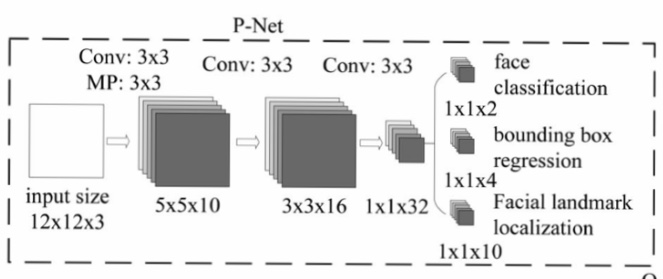

In [2]:
Image.open('PNet Model.jpg')

In [5]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.constant_(m.bias, 0.1)


class P_Net(nn.Module):
    def __init__(self):
        super(P_Net, self).__init__()
        self.pre_layer = nn.Sequential(
            # 12x12x3
            nn.Conv2d(3, 10, kernel_size=3, stride=1),  # conv1
            nn.PReLU(),  # PReLU1
            # 10x10x10
            nn.MaxPool2d(kernel_size=2, stride=2),  # pool1
            # 5x5x10
            nn.Conv2d(10, 16, kernel_size=3, stride=1),  # conv2
            # 3x3x16
            nn.PReLU(),  # PReLU2
            nn.Conv2d(16, 32, kernel_size=3, stride=1),  # conv3
            # 1x1x32
            nn.PReLU()  # PReLU3
        )
        # detection
        self.conv4_1 = nn.Conv2d(32, 1, kernel_size=1, stride=1)
        # bounding box regresion
        self.conv4_2 = nn.Conv2d(32, 4, kernel_size=1, stride=1)
        # landmark localization
        self.conv4_3 = nn.Conv2d(32, 10, kernel_size=1, stride=1)
        # weight initiation with xavier
        self.apply(weights_init)

    def forward(self, x):
        x = self.pre_layer(x)
        det = torch.sigmoid(self.conv4_1(x))
        box = self.conv4_2(x)
        landmark = self.conv4_3(x)
        # det:[,2,1,1], box:[,4,1,1], landmark:[,10,1,1]
        return det, box, landmark

## Loss Function and IoU Accuracy

- Loss Function:  
    - Face Classification: ( cls_loss)
$$ L^{det}_i = -\ ( y_i^{det}\ log (p_i)\ +\ (1 -  y_i^{det})\ (1\ -\ log ( p_i ) ) ) $$

    - Bounding Box Regression: ( box_loss)

$$ L^{box}_i = ||\ \hat{y}^{\ box}_i\ -\ y_i^{\ box}\ ||_2^2$$

- IoU: 
$$ \frac{inter\ area}{total\ area\ -\ inter\ area}$$

In [6]:
class LossFn:
    def __init__(self, cls_factor=1, box_factor=1):
        # loss function
        self.cls_factor = cls_factor
        self.box_factor = box_factor
        self.land_factor = landmark_factor
        self.loss_cls = nn.BCELoss()
        self.loss_box = nn.MSELoss()
        self.loss_landmark = nn.MSELoss()



    def cls_loss(self, gt_label, pred_label):
        # pred_label: [batch_size, 1, 1, 1] to [batch_size]
        pred_label = torch.squeeze(pred_label)
        # gt_label: [batch_size, 1] to [batch_size ]
        gt_label = torch.squeeze(gt_label)
        # get the mask element which >= 0, only 0 and 1 can effect the detection loss
        # mask = torch.ge(gt_label, 0)
        mask = torch.ge(gt_label, 0)        
        valid_gt_label = gt_label[mask]
        valid_pred_label = pred_label[mask]
        
        return self.loss_cls(valid_pred_label, valid_gt_label) * self.cls_factor
    
    

    def box_loss(self, gt_label, gt_offset, pred_offset):
        # if gt_label is torch.tensor([0.0]):
        #     return torch.tensor([0.0])
        # pred_offset: [batch_size, 4] to [batch_size,4]
        pred_offset = torch.squeeze(pred_offset)
        # gt_offset: [batch_size, 4, 1, 1] to [batch_size,4]
        gt_offset = torch.squeeze(gt_offset)
        # gt_label: [batch_size, 1, 1, 1] to [batch_size]
        gt_label = torch.squeeze(gt_label)

        # get the mask element which != 0
        # unmask = torch.eq(gt_label, 0)
        # mask = torch.eq(unmask, 0)
        mask = torch.eq(gt_label, 1)
        # convert mask to dim index
        
        valid_gt_offset = gt_offset[mask, :]
        valid_pred_offset = pred_offset[mask, :]
        # print('valid_gt_offset', valid_gt_offset, 'valid_pred_offset', valid_pred_offset)
        valid_sample_num = valid_gt_offset.shape[0]
        if 0 == valid_sample_num:
            # print('No box')
            # return self.loss_box(torch.tensor([0.0]), torch.tensor([0.0]))
            return torch.tensor([0.0])
        else:
            # print('valid_sample_num', valid_sample_num)
            return self.loss_box(valid_pred_offset, valid_gt_offset) * self.box_factor
        # return torch.tensor([0.])

    def total_loss(self, gt_label, pred_label, gt_offset, pred_offset, landmark_flag, gt_landmark, pred_landmark):
        return self.cls_loss(gt_label, pred_label) \
               + self.box_loss(gt_label, gt_offset, pred_offset))


In [7]:
def IoU(box, boxes):
    """
    Compute IoU between detect box and gt boxes
    """
    # box = (x1, y1, x2, y2)
    box_area = (box[2] - box[0] + 1) * (box[3] - box[1] + 1)
    area = (boxes[:, 2] - boxes[:, 0] + 1) * (boxes[:, 3] - boxes[:, 1] + 1)

    # abtain the offset of the interception of union between crop_box and gt_box
    xx1 = np.maximum(box[0], boxes[:, 0])
    yy1 = np.maximum(box[1], boxes[:, 1])
    xx2 = np.minimum(box[2], boxes[:, 2])
    yy2 = np.minimum(box[3], boxes[:, 3])

    # compute the width and height of the bounding box
    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)

    inter = w * h
    ovr = inter / (box_area + area - inter)
    return ovr


## Training 

In [8]:
def train_net(net, net_name='pnet',  loss_config=[]):
    # to show the loss curve
    train_losses=[]
    eval_losses=[]
    # to save the best loss weight
    best_eval_loss=100
    best_eval_weight=copy.deepcopy(net.state_dict())
          
    optimizer = opt.Adam(net.parameters(), lr=LR, betas=(0.9, 0.999), eps=1e-08, amsgrad=True)
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, 
        verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=2, min_lr=1e-08, eps=1e-08)
    loss = LossFn(cls_factor=loss_config[0], box_factor=loss_config[1], landmark_factor=loss_config[2])
    
    iter_count=0
    for epoch in range(EPOCH):
        net.train()
        t0 = time.perf_counter()
        train_loss=0        
        for (img_tensor, label, offset, landmark_flag, landmark) in Train_Loader:
            iter_count += 1
            wrap = (img_tensor, label, offset, landmark)
            (img_tensor, label, offset, landmark) = [i.cuda() for i in wrap]
            
            
            
            det, box, ldmk = net(img_tensor)
            if landmark==None:
                ldmk=None
            optimizer.zero_grad()
            
            all_loss = loss.total_loss(gt_label=label, pred_label=det, gt_offset=offset, pred_offset=box,
                                       landmark_flag=landmark_flag, pred_landmark=ldmk, gt_landmark=landmark)
            all_loss.backward()
            optimizer.step()
            train_loss+=all_loss.item()* img_tensor.size(0)
            

        t1 = time.perf_counter()
        train_loss=train_loss/train_num
        train_losses.append(train_loss)
        scheduler.step(train_loss)

        print('===> epoch:{}\t| train_loss:{:.8f}\t| time:{:.8f}s'.format(epoch, train_loss, t1 - t0)) 
        
        with torch.no_grad():
            eval_loss=0
            net.eval()
            for (img_tensor, label, offset, landmark_flag, landmark) in Eval_Loader:
                wrap = (img_tensor, label, offset, landmark)
                (img_tensor, label, offset, landmark) = [i.cuda() for i in wrap]
                det, box, ldmk = net(img_tensor)
                if landmark==None:
                    ldmk=None            
                all_loss = loss.total_loss(gt_label=label, pred_label=det, gt_offset=offset, pred_offset=box,
                                           landmark_flag=landmark_flag, pred_landmark=ldmk, gt_landmark=landmark)
                eval_loss+=all_loss.item() * img_tensor.size(0)  
                
                
        t2 = time.perf_counter()
        eval_loss=eval_loss/eval_num
        eval_losses.append(eval_loss)
        print('                | eval_loss:{:.8f}\t| time:{:.8f}s'.format(eval_loss, t2 - t1))
        if eval_loss< best_eval_loss:
            best_eval_loss=eval_loss
            best_eval_weight=copy.deepcopy(net.state_dict())
            
    torch.save(best_eval_weight, f'/kaggle/working/{train_num}_{EPOCH} best.pkl')
    torch.save(net.state_dict(), f'/kaggle/working/{train_num}_{EPOCH}.pkl')
    return train_losses, eval_losses,net
    

In [9]:
DEVICE = torch.device('cuda:0')
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')
train_txt_path='../input/wider-data/WIDER/wider_face_train_bbx_gt.txt'
eval_txt_path='../input/wider-data/WIDER/wider_face_val_bbx_gt.txt'
train_img_path='../input/wider-data/WIDER/WIDER_train'
eval_img_path='../input/wider-data/WIDER/WIDER_val'
train_num=10000
eval_num=1000
class_data_augment = 3 
landmark_data_dir = None 
landmark_data_txt_path = None 
LR = 0.001
EPOCH = 40
BATCH_SIZE = 32
NUM_WORKS = 8
Pnet_loss_config = [1.0, 0.5, 0.5]

train_img_faces = create_pnet_data_txt_parser(train_txt_path,train_img_path ,num_data=train_num)
eval_img_faces = create_pnet_data_txt_parser(eval_txt_path,eval_img_path ,num_data=eval_num)
train_IDS=InplaceDataset(train_img_faces, cropsize=12)
eval_IDS=InplaceDataset(eval_img_faces, cropsize=12)
Train_Loader=DataLoader(train_IDS,batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKS,pin_memory=False)
Eval_Loader=DataLoader(eval_IDS,batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKS,pin_memory=False)
train_num=len(train_IDS)
eval_num=len(eval_IDS)

net=P_Net().cuda()
for param in net.conv4_3.parameters():
    param.requires_grad = False

===> data set size:10000
===> data set size:1000


In [10]:
train_losses,eval_losses,pnet=train_net(net, net_name='pnet',  loss_config=Pnet_loss_config)

===> epoch:0	| train_loss:0.53917849	| time:300.77083234s
                | eval_loss:0.43567619	| time:30.66130990s
===> epoch:1	| train_loss:0.42999499	| time:302.99674564s
                | eval_loss:0.40498244	| time:30.63828552s
===> epoch:2	| train_loss:0.41198416	| time:300.33597679s
                | eval_loss:0.41750545	| time:30.95084757s
===> epoch:3	| train_loss:0.39966442	| time:302.97692628s
                | eval_loss:0.39708375	| time:30.34120916s
===> epoch:4	| train_loss:0.38998464	| time:300.42367602s
                | eval_loss:0.37135400	| time:30.69436906s
===> epoch:5	| train_loss:0.39255014	| time:301.18510636s
                | eval_loss:0.37886463	| time:29.73236319s
===> epoch:6	| train_loss:0.37327957	| time:307.91796116s
                | eval_loss:0.39837465	| time:29.52675622s
===> epoch:7	| train_loss:0.37299433	| time:298.98639667s
                | eval_loss:0.35476269	| time:30.66491934s
===> epoch:8	| train_loss:0.36517254	| time:301.01042897s
      

## Show the Loss Curve

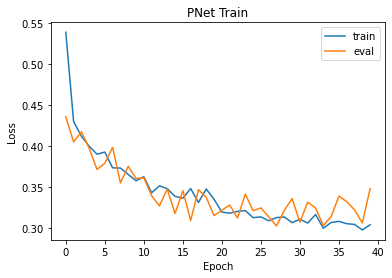

In [11]:
x=np.arange(len(train_losses))
plt.plot(x,train_losses,label='train')
plt.plot(x,eval_losses,label='eval')
plt.title('PNet Train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()